In [2]:
# mediapipe
# opencv-python
# matplotlib
# seaborn
# pandas
# scikit-learn
# xgboost

Pembuatan Dataset

In [2]:
import cv2
import mediapipe as mp
import os
import pandas as pd

# Inisialisasi MediaPipe Pose dan drawing utilities
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils
pose = mp_pose.Pose(static_image_mode=True)

# Definisi kelas dan keypoints yang akan diekstrak
classes = ['looks good', 'shoulders back', 'sit up', 'straighten head']
keypoints_to_extract = [
    mp_pose.PoseLandmark.NOSE,
    mp_pose.PoseLandmark.LEFT_SHOULDER, mp_pose.PoseLandmark.RIGHT_SHOULDER,
    mp_pose.PoseLandmark.LEFT_HIP, mp_pose.PoseLandmark.RIGHT_HIP,
    mp_pose.PoseLandmark.LEFT_EAR, mp_pose.PoseLandmark.RIGHT_EAR,
    mp_pose.PoseLandmark.LEFT_EYE, mp_pose.PoseLandmark.RIGHT_EYE
]

# Buat folder untuk menyimpan gambar dengan keypoints
output_folder = "./keypoints_visualizations"
os.makedirs(output_folder, exist_ok=True)

data = []

# Proses setiap gambar dalam folder
for label in classes:
    folder_path = f"./train/{label}"
    for file in os.listdir(folder_path):
        img_path = os.path.join(folder_path, file)
        image = cv2.imread(img_path)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        result = pose.process(image_rgb)

        if result.pose_landmarks:
            # Ekstraksi data untuk CSV
            row = []
            for kp in keypoints_to_extract:
                landmark = result.pose_landmarks.landmark[kp]
                row.extend([landmark.x, landmark.y])
            row.append(label)
            data.append(row)

            # Buat salinan gambar untuk annotasi
            annotated_image = image.copy()
            
            # Gambar keypoints dan koneksi
            mp_drawing.draw_landmarks(
                annotated_image, 
                result.pose_landmarks, 
                mp_pose.POSE_CONNECTIONS,
                # Warna untuk keypoints (hijau)
                mp_drawing.DrawingSpec(color=(0, 255, 0), thickness=2, circle_radius=4),
                # Warna untuk koneksi (merah)
                mp_drawing.DrawingSpec(color=(255, 0, 0), thickness=2, circle_radius=2)
            )

            # Tambahkan label pada gambar
            cv2.putText(annotated_image, label, (10, 30), 
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

            # Simpan gambar dengan keypoints
            output_filename = os.path.join(output_folder, f"{label}_{file}")
            cv2.imwrite(output_filename, annotated_image)

# Tutup pose
pose.close()

# Buat DataFrame dan simpan ke CSV
columns = [f"{kp.name}_{axis}" for kp in keypoints_to_extract for axis in ['x', 'y']]
df = pd.DataFrame(data, columns=columns + ['label'])
df.to_csv("pose_dataset.csv", index=False)

print("Proses selesai. Visualisasi disimpan di folder:", output_folder)


: 

Helping functions

In [2]:
import mediapipe as mp
import cv2
import matplotlib.pyplot as plt

mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

def predict_posture(image_path, model):
    with mp_pose.Pose(static_image_mode=True) as pose:
        image = cv2.imread(image_path)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        result = pose.process(image_rgb)

        if result.pose_landmarks:
            # Draw landmarks
            annotated_image = image_rgb.copy()
            mp_drawing.draw_landmarks(
                annotated_image,
                result.pose_landmarks,
                mp_pose.POSE_CONNECTIONS,
                landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style()
            )

            # Extract key points
            row = []
            keypoints_to_extract = [
                mp_pose.PoseLandmark.NOSE,
                mp_pose.PoseLandmark.LEFT_SHOULDER, mp_pose.PoseLandmark.RIGHT_SHOULDER,
                mp_pose.PoseLandmark.LEFT_HIP, mp_pose.PoseLandmark.RIGHT_HIP,
                mp_pose.PoseLandmark.LEFT_EAR, mp_pose.PoseLandmark.RIGHT_EAR,
                mp_pose.PoseLandmark.LEFT_EYE, mp_pose.PoseLandmark.RIGHT_EYE
            ]
            for kp in keypoints_to_extract:
                landmark = result.pose_landmarks.landmark[kp]
                row.extend([landmark.x, landmark.y])

            # Predict
            prediction = model.predict([row])[0]

            # Plot the annotated image
            plt.figure(figsize=(6, 6))
            plt.imshow(annotated_image)
            plt.title(f"Predicted Posture: {prediction}")
            plt.axis('off')
            plt.show()

            return prediction
        else:
            print("No person detected")
            return "No person detected"
        

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

def plot_classification_metrics_from_model(model, y_true, y_pred):
    """
    Plots confusion matrix and precision/recall/F1-score bars for any trained model.

    Args:
        model: Trained classifier (must have `.classes_` attribute)
        y_true: Ground truth labels
        y_pred: Predicted labels
    """
    class_names = model.classes_

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred, labels=class_names)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # Precision, Recall, F1-score
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, labels=class_names)
    metrics_df = pd.DataFrame({
        'Class': class_names,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    })
    metrics_melted = metrics_df.melt(id_vars='Class', var_name='Metric', value_name='Score')

    plt.figure(figsize=(10, 6))
    sns.barplot(data=metrics_melted, x='Class', y='Score', hue='Metric')
    plt.title("Classification Metrics per Class")
    plt.ylim(0, 1.05)
    plt.legend(loc='upper right')
    plt.show()


RANDOM FOREST 

                 precision    recall  f1-score   support

     looks good       0.81      0.80      0.80        79
 shoulders back       0.84      0.85      0.85        75
         sit up       0.86      0.80      0.83        30
straighten head       0.90      0.92      0.91        77

       accuracy                           0.85       261
      macro avg       0.85      0.84      0.85       261
   weighted avg       0.85      0.85      0.85       261



c:\Users\Axioo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


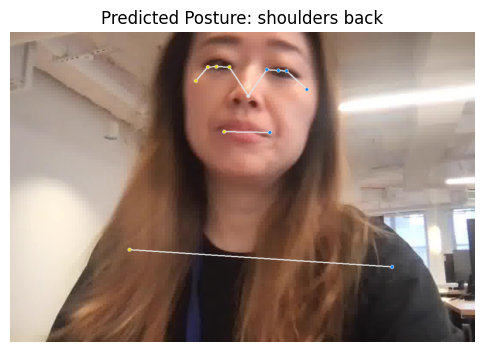

shoulders back


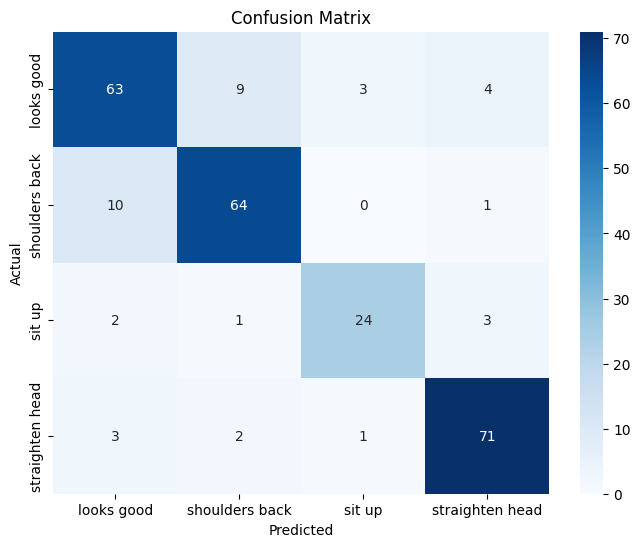

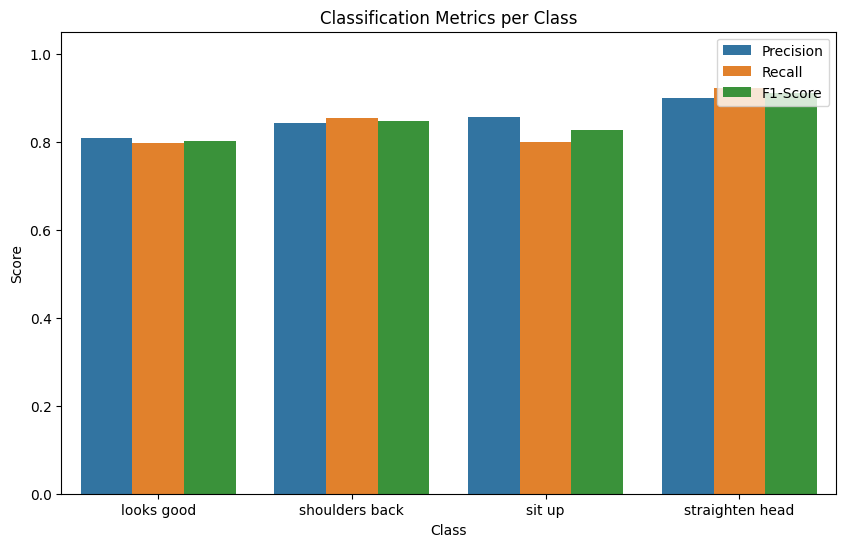

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV

df = pd.read_csv("pose_dataset.csv")
X = df.drop("label", axis=1)
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 2, 3]
}

search = RandomizedSearchCV(RandomForestClassifier(), param_grid, n_iter=20, cv=5, n_jobs=-1)
search.fit(X_train, y_train)

clf = search.best_estimator_
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
print(predict_posture("test.jpg",clf))
plot_classification_metrics_from_model(clf, y_test, y_pred)


xgboost model

c:\Users\Axioo\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:52:43] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


                 precision    recall  f1-score   support

     looks good       0.79      0.76      0.77        79
 shoulders back       0.80      0.87      0.83        75
         sit up       0.86      0.80      0.83        30
straighten head       0.92      0.91      0.92        77

       accuracy                           0.84       261
      macro avg       0.84      0.83      0.84       261
   weighted avg       0.84      0.84      0.84       261



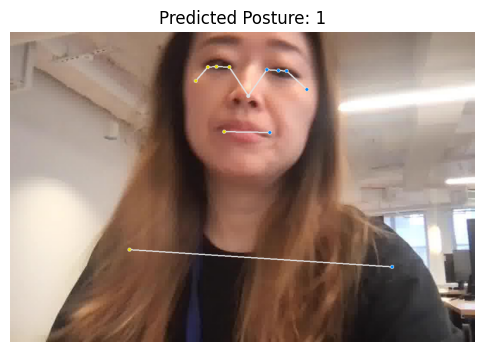

shoulders back


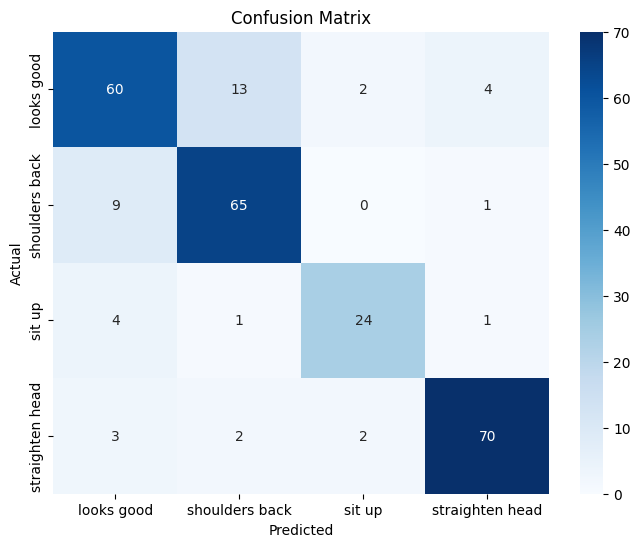

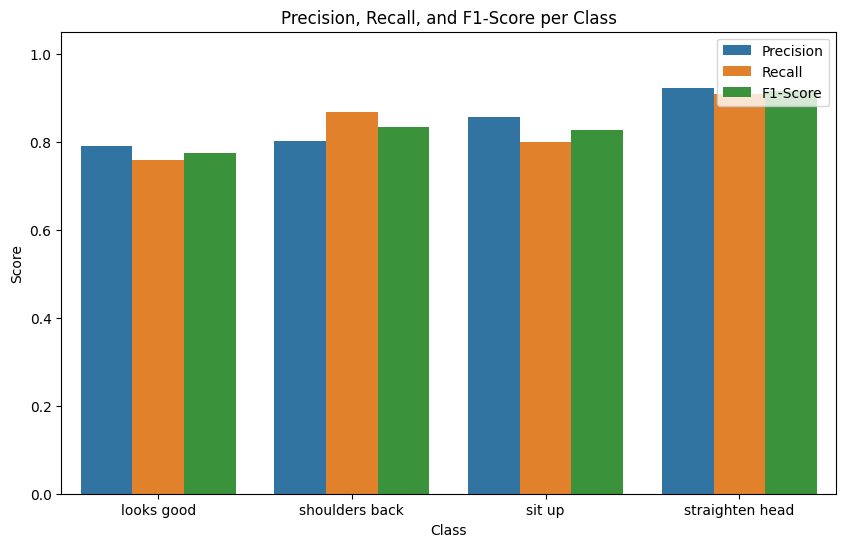

In [6]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load and encode labels
df = pd.read_csv("pose_dataset.csv")
X = df.drop("label", axis=1)
y = df["label"]

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # Labels become 0, 1, 2, 3

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

# Randomized search
search = RandomizedSearchCV(
    XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
    param_distributions=param_grid,
    n_iter=20, cv=5, n_jobs=-1, random_state=42
)
search.fit(X_train, y_train)
clf = search.best_estimator_

# Predict and decode
y_pred_encoded = clf.predict(X_test)
y_pred = label_encoder.inverse_transform(y_pred_encoded)
y_test_decoded = label_encoder.inverse_transform(y_test)

# Classification report
print(classification_report(y_test_decoded, y_pred))

# Prediction on new image
def predict_posture_decoded(image_path, model, label_encoder):
    encoded_pred = predict_posture(image_path, model)  # returns int
    return label_encoder.inverse_transform([encoded_pred])[0]

print(predict_posture_decoded("test.jpg", clf, label_encoder))

# ==== Plotting directly ====

# Confusion Matrix
class_names = label_encoder.classes_
cm = confusion_matrix(y_test_decoded, y_pred, labels=class_names)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Precision, Recall, F1-Score bar plot
precision, recall, f1, _ = precision_recall_fscore_support(y_test_decoded, y_pred, labels=class_names)
metrics_df = pd.DataFrame({
    'Class': class_names,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1
})
metrics_melted = metrics_df.melt(id_vars='Class', var_name='Metric', value_name='Score')

plt.figure(figsize=(10, 6))
sns.barplot(data=metrics_melted, x='Class', y='Score', hue='Metric')
plt.title("Precision, Recall, and F1-Score per Class")
plt.ylim(0, 1.05)
plt.legend(loc='upper right')
plt.show()


MLPClassifier

                 precision    recall  f1-score   support

     looks good       0.81      0.80      0.80        79
 shoulders back       0.83      0.87      0.85        75
         sit up       0.89      0.83      0.86        30
straighten head       0.92      0.92      0.92        77

       accuracy                           0.86       261
      macro avg       0.86      0.85      0.86       261
   weighted avg       0.86      0.86      0.86       261



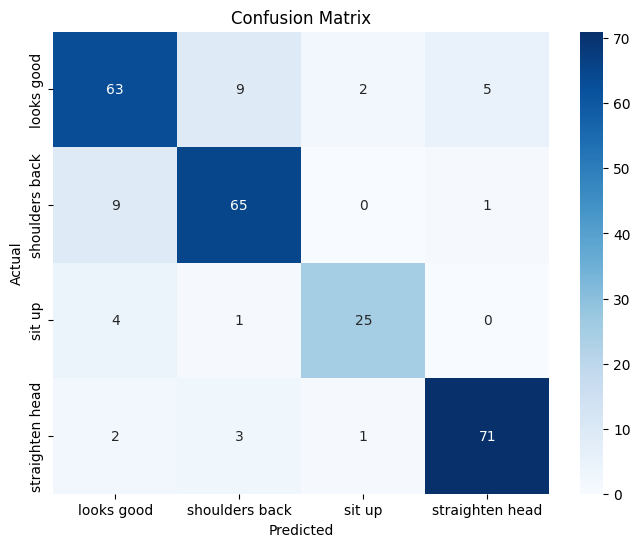

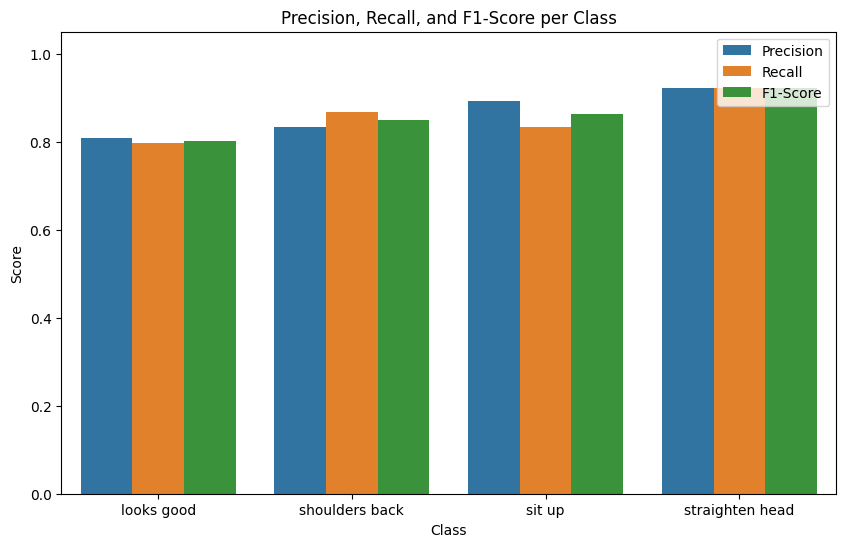

In [9]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neural_network import MLPClassifier
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

# Load and encode labels
df = pd.read_csv("pose_dataset.csv")
X = df.drop("label", axis=1)
y = df["label"]

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split scaled data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

# Parameter grid for MLPClassifier
param_grid = {
    'hidden_layer_sizes': [(64,), (128,), (64, 32), (128, 64)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam'],
    'alpha': [0.0001, 0.001],
    'learning_rate_init': [0.001, 0.01]
}

# RandomizedSearchCV to tune MLP
search = RandomizedSearchCV(
    MLPClassifier(max_iter=1000),
    param_distributions=param_grid,
    n_iter=10,
    cv=5,
    n_jobs=-1,
    random_state=42
)
search.fit(X_train, y_train)
clf = search.best_estimator_

# Predict and decode
y_pred_encoded = clf.predict(X_test)
y_pred = label_encoder.inverse_transform(y_pred_encoded)
y_test_decoded = label_encoder.inverse_transform(y_test)

# Classification report
print(classification_report(y_test_decoded, y_pred))



# Save model, scaler, and label encoder
joblib.dump(clf, "best-model/mlp_posture_model.pkl")
joblib.dump(scaler, "best-model/scaler.pkl")
joblib.dump(label_encoder, "best-model/label_encoder.pkl")


# === Plotting ===

# Confusion Matrix
class_names = label_encoder.classes_
cm = confusion_matrix(y_test_decoded, y_pred, labels=class_names)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Precision, Recall, F1-Score bar plot
precision, recall, f1, _ = precision_recall_fscore_support(y_test_decoded, y_pred, labels=class_names)
metrics_df = pd.DataFrame({
    'Class': class_names,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1
})
metrics_melted = metrics_df.melt(id_vars='Class', var_name='Metric', value_name='Score')

plt.figure(figsize=(10, 6))
sns.barplot(data=metrics_melted, x='Class', y='Score', hue='Metric')
plt.title("Precision, Recall, and F1-Score per Class")
plt.ylim(0, 1.05)
plt.legend(loc='upper right')
plt.show()


Implementasi pakai best model (MLPClassifier)

Predicted posture: shoulders back


c:\Users\Axioo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


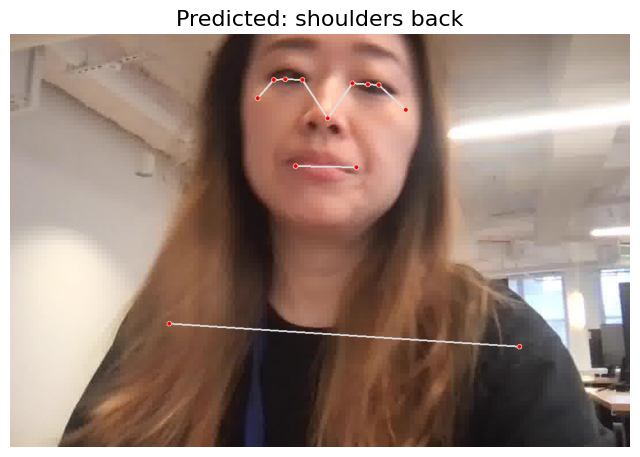

In [10]:
import joblib

import cv2
import mediapipe as mp
import numpy as np

def extract_pose_features(image_path):
    """
    Extracts selected pose landmarks (x, y) from the image using MediaPipe.
    Returns a flat feature list and the image with pose landmarks drawn.
    """
    mp_pose = mp.solutions.pose
    mp_drawing = mp.solutions.drawing_utils
    pose = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.5)

    image = cv2.imread(image_path)
    if image is None:
        print("❌ Could not load image:", image_path)
        return None, None

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = pose.process(image_rgb)

    if not results.pose_landmarks:
        print("❌ No pose detected.")
        return None, image

    h, w = image.shape[:2]
    landmarks = results.pose_landmarks.landmark

    # Select key landmarks for your model (same as training)
    keypoints = [
        mp_pose.PoseLandmark.NOSE,
        mp_pose.PoseLandmark.LEFT_SHOULDER, mp_pose.PoseLandmark.RIGHT_SHOULDER,
        mp_pose.PoseLandmark.LEFT_HIP, mp_pose.PoseLandmark.RIGHT_HIP,
        mp_pose.PoseLandmark.LEFT_EAR, mp_pose.PoseLandmark.RIGHT_EAR,
        mp_pose.PoseLandmark.LEFT_EYE, mp_pose.PoseLandmark.RIGHT_EYE
    ]

    features = []
    for kp in keypoints:
        x = landmarks[kp.value].x
        y = landmarks[kp.value].y
        features.extend([x, y])  # No need to scale — your scaler will handle it

    # Draw landmarks
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)

    return features, image


# Load everything
clf = joblib.load("best-model/mlp_posture_model.pkl")
scaler = joblib.load("best-model/scaler.pkl")
label_encoder = joblib.load("best-model/label_encoder.pkl")




# Example usage:
features, image = extract_pose_features("test.jpg")

if features:
    # Scale and predict
    features_scaled = scaler.transform([features])
    pred_encoded = clf.predict(features_scaled)[0]
    pred_label = label_encoder.inverse_transform([pred_encoded])[0]
    
    # Print prediction
    print("Predicted posture:", pred_label)

    # Convert BGR → RGB for matplotlib display
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Plot the image with prediction title
    plt.figure(figsize=(8, 8))
    plt.imshow(image_rgb)
    plt.title(f"Predicted: {pred_label}", fontsize=16)
    plt.axis('off')
    plt.show()

else:
    print("Pose could not be detected in the image.")



Implementasi Real Time pakai best model (MLPClassifier)

In [1]:
import cv2
import mediapipe as mp
import numpy as np
import joblib

# Load model, scaler, encoder
clf = joblib.load("best-model/mlp_posture_model.pkl")
scaler = joblib.load("best-model/scaler.pkl")
label_encoder = joblib.load("best-model/label_encoder.pkl")

# Initialize MediaPipe
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils
pose = mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.5, min_tracking_confidence=0.5)

# Webcam capture
cap = cv2.VideoCapture(0)

# Key landmarks used in training
keypoints = [
    mp_pose.PoseLandmark.NOSE,
    mp_pose.PoseLandmark.LEFT_SHOULDER, mp_pose.PoseLandmark.RIGHT_SHOULDER,
    mp_pose.PoseLandmark.LEFT_HIP, mp_pose.PoseLandmark.RIGHT_HIP,
    mp_pose.PoseLandmark.LEFT_EAR, mp_pose.PoseLandmark.RIGHT_EAR,
    mp_pose.PoseLandmark.LEFT_EYE, mp_pose.PoseLandmark.RIGHT_EYE
]

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Flip and convert to RGB
    frame = cv2.flip(frame, 1)
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Process with MediaPipe
    results = pose.process(frame_rgb)

    if results.pose_landmarks:
        h, w = frame.shape[:2]
        landmarks = results.pose_landmarks.landmark
        features = []

        for kp in keypoints:
            x = landmarks[kp.value].x
            y = landmarks[kp.value].y
            features.extend([x, y])

        # Predict posture
        features_scaled = scaler.transform([features])
        pred_encoded = clf.predict(features_scaled)[0]
        pred_label = label_encoder.inverse_transform([pred_encoded])[0]

        # Draw landmarks and label
        mp_drawing.draw_landmarks(frame, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)
        cv2.putText(frame, f"Posture: {pred_label}", (10, 40), cv2.FONT_HERSHEY_SIMPLEX, 1.0,
                    (0, 255, 0) if "good" in pred_label.lower() else (0, 0, 255), 2)

    else:
        cv2.putText(frame, "No person detected", (10, 40), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (255, 255, 0), 2)

    # Show the frame
    cv2.imshow("Posture Detection (MLP Inference)", frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release everything
cap.release()
cv2.destroyAllWindows()


c:\Users\Axioo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Axioo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Axioo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Axioo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Axioo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: U

KeyboardInterrupt: 